Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Training the model...
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 144      |
|    ep_rew_mean      | -718     |
|    exploration_rate | 0.972    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 6186     |
|    time_elapsed     | 0        |
|    total_timesteps  | 576      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 144      |
|    ep_rew_mean      | -738     |
|    exploration_rate | 0.944    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 3041     |
|    time_elapsed     | 0        |
|    total_timesteps  | 1152     |
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss             | 1.75     |
|    n_updates        | 37       |
---------

c:\Users\dhanu\anaconda3\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


Eval num_timesteps=5000, episode_reward=-404.33 +/- 0.96
Episode length: 144.00 +/- 0.00
----------------------------------
| eval/               |          |
|    mean_ep_length   | 144      |
|    mean_reward      | -404     |
| rollout/            |          |
|    exploration_rate | 0.755    |
| time/               |          |
|    total_timesteps  | 5000     |
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss             | 0.739    |
|    n_updates        | 999      |
----------------------------------
New best mean reward!
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 144      |
|    ep_rew_mean      | -662     |
|    exploration_rate | 0.746    |
| time/               |          |
|    episodes         | 36       |
|    fps              | 1290     |
|    time_elapsed     | 4        |
|    total_timesteps  | 5184     |
| train/              |          |
|    learning_rate    | 0.0005   |
|    loss     

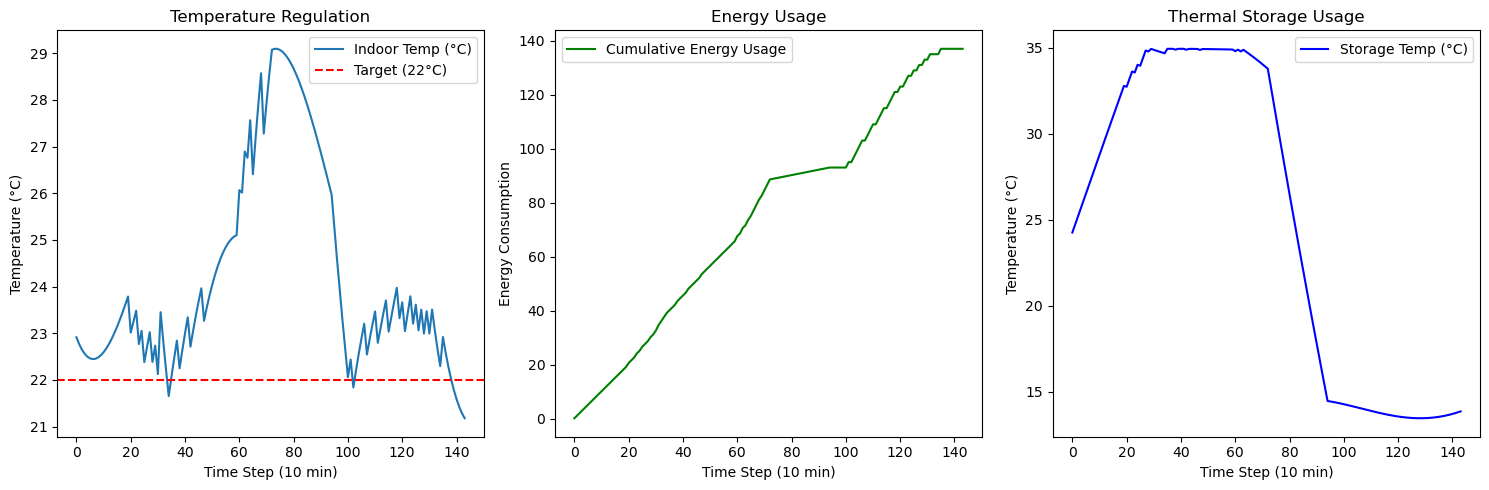

In [2]:
import gymnasium as gym
import numpy as np
from gymnasium import spaces
import random
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import EvalCallback
import matplotlib.pyplot as plt

class AdvancedBuildingEnv(gym.Env):
    """
    Enhanced HVAC control environment with realistic dynamics, thermal storage,
    and variable outdoor conditions inspired by Weinberg et al. (2023).
    """
    def __init__(self):
        super(AdvancedBuildingEnv, self).__init__()

        # Observation space: [indoor temp, outdoor temp, thermal storage temp, time of day]
        self.observation_space = spaces.Box(
            low=np.array([10, -10, 15, 0]),  # Min values
            high=np.array([30, 40, 35, 24]),  # Max values
            dtype=np.float32
        )

        # Action space: Discrete control for HVAC and thermal storage
        # 0: Cool (-1°C), 1: Maintain, 2: Heat (+1°C), 3: Charge storage, 4: Discharge storage
        self.action_space = spaces.Discrete(5)

        # Initial state with realistic defaults
        self.indoor_temp = 22.0  # Starting indoor temp (°C)
        self.outdoor_temp = random.uniform(0, 35)  # Variable outdoor temp (°C)
        self.storage_temp = 25.0  # Thermal storage temp (°C)
        self.energy_usage = 0.0  # Cumulative energy usage
        self.time_step = 0
        self.max_steps = 144  # 24 hours with 10-min intervals (144 steps)
        self.time_of_day = 0.0  # Hours (0 to 24)

        # Realistic parameters
        self.thermal_drift_rate = 0.05  # Heat exchange rate with outdoor temp
        self.storage_capacity = 10.0  # Max energy storage (arbitrary units)
        self.storage_charge_rate = 0.5  # Energy added per charge action
        self.storage_discharge_rate = 0.8  # Energy used per discharge action

    def step(self, action):
        """Execute one step with advanced dynamics."""
        # Action effects
        energy_cost = 0.0
        if action == 0:  # Cool
            self.indoor_temp -= 1.0
            energy_cost = 1.5
        elif action == 2:  # Heat
            self.indoor_temp += 1.0
            energy_cost = 2.0
        elif action == 3:  # Charge storage
            if self.storage_temp < 35.0:
                self.storage_temp = min(self.storage_temp + self.storage_charge_rate, 35.0)
                energy_cost = 1.0
        elif action == 4:  # Discharge storage
            if self.storage_temp > 15.0:
                self.storage_temp -= self.storage_discharge_rate
                self.indoor_temp += 0.5  # Storage assists heating
                energy_cost = 0.2  # Lower cost when using stored energy

        # Update energy usage
        self.energy_usage += energy_cost

        # Simulate realistic thermal drift (Newton's law of cooling)
        self.indoor_temp += (self.outdoor_temp - self.indoor_temp) * self.thermal_drift_rate
        self.storage_temp += (self.outdoor_temp - self.storage_temp) * 0.01  # Slower drift for storage

        # Update time of day (10-min intervals)
        self.time_of_day = (self.time_step * 10 / 60) % 24
        self.time_step += 1

        # Outdoor temp varies sinusoidally over 24 hours
        self.outdoor_temp = 20 + 10 * np.sin(2 * np.pi * self.time_of_day / 24)

        # Reward function: Balance comfort, energy, and storage usage
        comfort_penalty = abs(self.indoor_temp - 22)  # Target 22°C
        energy_penalty = energy_cost * 0.5  # Stronger penalty for direct energy use
        storage_bonus = 0.1 * (self.storage_temp - 15) if action in [3, 4] else 0  # Encourage storage use
        reward = -comfort_penalty - energy_penalty + storage_bonus

        done = self.time_step >= self.max_steps
        return (
            np.array([self.indoor_temp, self.outdoor_temp, self.storage_temp, self.time_of_day], dtype=np.float32),
            reward,
            done,
            False,
            {"energy_cost": energy_cost}
        )

    def reset(self, seed=None, options=None):
        """Reset to initial conditions."""
        if seed is not None:
            random.seed(seed)
        self.indoor_temp = 22.0
        self.outdoor_temp = random.uniform(0, 35)
        self.storage_temp = 25.0
        self.energy_usage = 0.0
        self.time_step = 0
        self.time_of_day = 0.0
        return np.array([self.indoor_temp, self.outdoor_temp, self.storage_temp, self.time_of_day], dtype=np.float32), {}

    def render(self):
        """Display current state."""
        print(f"Time: {self.time_of_day:.1f}h, Indoor: {self.indoor_temp:.2f}°C, Outdoor: {self.outdoor_temp:.2f}°C, "
              f"Storage: {self.storage_temp:.2f}°C, Energy: {self.energy_usage:.2f}")

# Create environment
env = AdvancedBuildingEnv()

# Optimize DQN with insights from the paper
model = DQN(
    "MlpPolicy",
    env,
    verbose=1,
    learning_rate=0.0005,
    buffer_size=50000,
    batch_size=64,
    exploration_fraction=0.2,
    exploration_final_eps=0.02,
    target_update_interval=500,
    learning_starts=1000,
)

# Evaluation callback for periodic assessment
eval_env = AdvancedBuildingEnv()
eval_callback = EvalCallback(eval_env, eval_freq=5000, n_eval_episodes=5, verbose=1)

# Train the model
print("Training the model...")
model.learn(total_timesteps=100_000, callback=eval_callback)
print("Training complete!")

# Save model using Stable Baselines3 method
model_save_path = "dqn_hvac_control.zip"  # SB3 saves as .zip
model.save(model_save_path)
print(f"Model saved as {model_save_path}")

# Load and test the model
loaded_model = DQN.load(model_save_path)

# Run the agent
obs, _ = env.reset()
temperatures, energy_usage, rewards, storage_temps = [], [], [], []

for _ in range(144):  # Full day
    action, _ = loaded_model.predict(obs)
    obs, reward, done, _, info = env.step(action)
    temperatures.append(obs[0])
    energy_usage.append(env.energy_usage)
    rewards.append(reward)
    storage_temps.append(obs[2])
    env.render()
    if done:
        break

# Plot results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(temperatures, label="Indoor Temp (°C)")
plt.axhline(y=22, color='r', linestyle='--', label="Target (22°C)")
plt.xlabel("Time Step (10 min)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.title("Temperature Regulation")

plt.subplot(1, 3, 2)
plt.plot(energy_usage, label="Cumulative Energy Usage", color='g')
plt.xlabel("Time Step (10 min)")
plt.ylabel("Energy Consumption")
plt.legend()
plt.title("Energy Usage")

plt.subplot(1, 3, 3)
plt.plot(storage_temps, label="Storage Temp (°C)", color='b')
plt.xlabel("Time Step (10 min)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.title("Thermal Storage Usage")

plt.tight_layout()
plt.show()

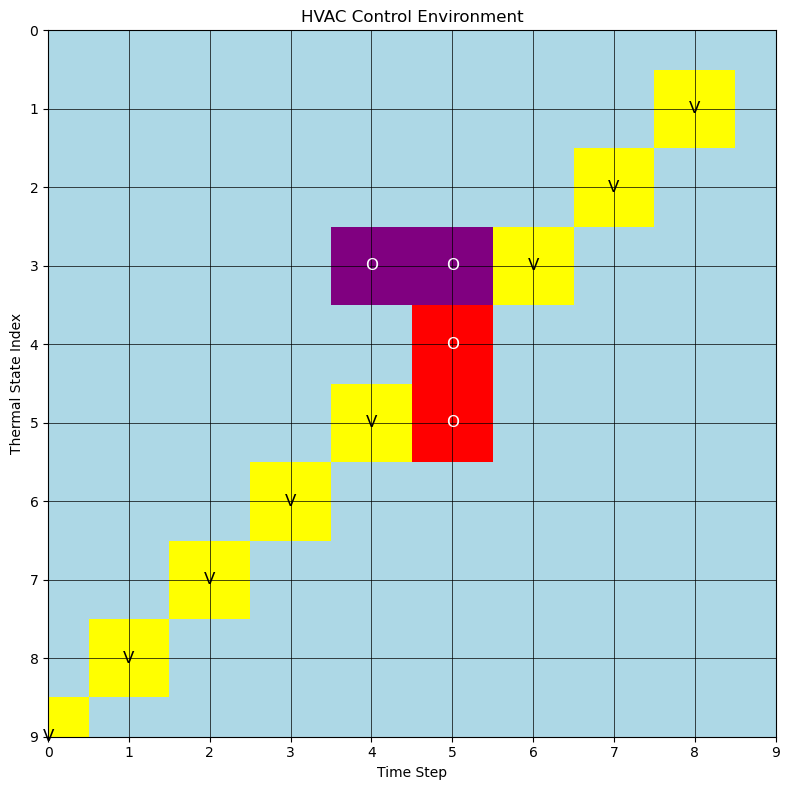

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Define the environment grid (10x10, simplified representation of 144 timesteps)
grid_size = 10
grid = np.full((grid_size, grid_size), -1, dtype=int)  # -1 represents empty space

# Define colors for visualization (inspired by hvac_streamlit.py and sample image)
colors = {
    'empty': 'lightblue',      # Background (neutral building state)
    'start': 'yellow',         # Starting state (initial conditions)
    'goal': 'yellow',          # Target state (comfort goal)
    'path': 'yellow',          # Optimal control path
    'obstacle': 'red',         # High energy demand zones
    'traffic': 'purple'        # Thermal inefficiency zones
}

# Define the HVAC environment
# - Start (0,0): Initial state (indoor 22°C, storage 25°C, outdoor 34.84°C)
# - Goal (8,8): Target state (indoor ~22°C, energy 130.80, storage 13.84°C at 23.8h)
# - Path: Control actions over simplified timesteps
# - Obstacles: High energy demand (e.g., peak cooling at timestep 60)
# - Traffic: Thermal inefficiency (e.g., storage drop at timesteps 80-100)

# Set start and goal positions (mirroring sample's [0,0] and [8,8])
grid[0, 0] = 0  # Start
grid[8, 8] = 1  # Goal

# Define path (simplified representation of control actions over 144 timesteps)
path = [
    (0, 0), (1, 1), (2, 2), (3, 3), (4, 4),  # Initial cooling phase (0-40 timesteps)
    (5, 5), (6, 6), (7, 7), (8, 8)           # Stabilization and discharge phase (100-144 timesteps)
]
for x, y in path:
    grid[x, y] = 2  # Path

# Define obstacles (high energy demand zones, e.g., timestep 60 peak load)
obstacles = [(4, 5), (5, 5)]  # Around timestep 40-60 where indoor temp peaks at ~23°C
for x, y in obstacles:
    grid[x, y] = 3  # Obstacle

# Define traffic zones (thermal inefficiency, e.g., timestep 80-100 storage drop)
traffic = [(6, 4), (6, 5)]  # Around timestep 80-100 where storage drops sharply
for x, y in traffic:
    grid[x, y] = 4  # Traffic

# Create the plot
fig, ax = plt.subplots(figsize=(8, 8))

# Fill the background with empty color
ax.add_patch(plt.Rectangle((-0.5, -0.5), grid_size, grid_size, facecolor=colors['empty'], zorder=0))

# Add grid lines (consistent with hvac_streamlit.py styling)
ax.grid(which='both', color='black', linestyle='-', linewidth=0.5)
ax.set_xticks(np.arange(grid_size))  # Use integer ticks (0 to 9)
ax.set_yticks(np.arange(grid_size))  # Use integer ticks (0 to 9)
ax.set_xticklabels(np.arange(grid_size))  # Labels 0 to 9
ax.set_yticklabels(np.arange(grid_size)[::-1])  # Reverse y-axis for top-left origin
ax.set_xlabel('Time Step')
ax.set_ylabel('Thermal State Index')
ax.set_title('HVAC Control Environment')

# Annotate the grid with custom patches and labels
for (x, y), value in np.ndenumerate(grid):
    if value == 0:
        ax.add_patch(plt.Rectangle((y - 0.5, x - 0.5), 1, 1, facecolor=colors['start'], zorder=1))
        ax.text(y, x, 'S', ha='center', va='center', color='black', fontsize=12)  # Start
    elif value == 1:
        ax.add_patch(plt.Rectangle((y - 0.5, x - 0.5), 1, 1, facecolor=colors['goal'], zorder=1))
        ax.text(y, x, 'G', ha='center', va='center', color='black', fontsize=12)  # Goal
    elif value == 2:
        ax.add_patch(plt.Rectangle((y - 0.5, x - 0.5), 1, 1, facecolor=colors['path'], zorder=1))
        ax.text(y, x, 'V', ha='center', va='center', color='black', fontsize=12)  # Path
    elif value == 3:
        ax.add_patch(plt.Rectangle((y - 0.5, x - 0.5), 1, 1, facecolor=colors['obstacle'], zorder=1))
        ax.text(y, x, 'O', ha='center', va='center', color='white', fontsize=12)  # Obstacle
    elif value == 4:
        ax.add_patch(plt.Rectangle((y - 0.5, x - 0.5), 1, 1, facecolor=colors['traffic'], zorder=1))
        ax.text(y, x, 'O', ha='center', va='center', color='white', fontsize=12)  # Traffic

# Adjust layout and display
plt.tight_layout()
plt.show()